In [1]:
%load_ext autotime

In [2]:
# Importar librerias
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import numpy as np

import zipfile
from datetime import date
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report


from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

from numpy.testing import assert_allclose

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, GlobalMaxPool1D, Conv1D, Flatten,  MaxPooling1D, Activation, GlobalMaxPooling1D, Bidirectional, GRU
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta

import os
from pathlib import Path


time: 41.9 s


In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

time: 1.41 ms


In [4]:
exp_name = '7_c'
folder = 'Resultados/' + exp_name
my_file = Path(folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(folder)
    


already exists
time: 1.68 ms


In [5]:
ch_folder = folder + '/Checkpoints'
my_file = Path(ch_folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(ch_folder)

already exists
time: 1.6 ms


### Read datasets

In [6]:
#Importar los datasets
url_embeddings_average_individual = zipfile.ZipFile('../Data/sum_topics.zip')

embeddings_average_individual = pd.read_csv(url_embeddings_average_individual.open('sum_topics.csv'))


embeddings_average_individual['Date'] =  pd.to_datetime(embeddings_average_individual['Date'], format='%Y-%m-%d')

embeddings_average_individual.reset_index()
embeddings_average_individual.fillna(0, inplace=True)
embeddings_average_individual.tail(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
49649,-0.492432,0.599487,-0.093018,0.693359,-0.435669,0.422607,0.255676,-0.246155,0.072754,-0.123047,0.260254,-1.105225,-0.861328,0.712006,-0.057861,0.604210,-0.070557,0.921875,-0.253174,-0.049194,0.509827,-0.094482,0.330078,-0.333115,-0.522522,-1.142212,0.393860,-0.221680,0.310547,-0.728760,-0.543945,-0.105408,-0.695801,0.081055,0.059509,-0.523254,-0.332424,0.226318,0.164551,1.169922,-0.001709,-0.466415,0.883545,-0.151978,0.344681,-0.574351,-0.012207,0.78125,-1.159424,0.613647,-0.368536,0.491577,-0.683350,0.499237,0.472900,-0.878418,-0.342377,0.133621,0.046997,-1.108765,0.212402,0.634277,0.986328,-0.915161,-0.344727,0.647949,0.238525,0.470703,-0.391079,0.539062,-0.365234,-0.641724,0.220276,-0.104639,-0.633545,-0.388855,-0.221191,-0.955444,-1.069092,0.416504,0.083984,-0.89978,0.149170,0.351822,-0.302734,-0.247536,-1.155273,0.153753,0.148926,-0.778564,0.809753,-0.926025,-0.226562,-0.794434,0.538044,0.575439,0.972168,0.004501,1.219727,0.657959,0.019409,1.007690,-0.352432,0.953613,0.660156,-0.411011,0.151123,-0.057129,0.549316,-0.941864,-0.280273,0.674316,0.817871,-0.033081,0.217041,-0.405029,-0.095459,-0.589111,0.143066,0.345703,-1.480469,0.490479,-0.330811,-0.719460,0.008667,-0.819824,0.159012,0.303375,-0.033234,0.617432,-0.545166,0.055664,-0.759766,-0.610535,-1.591797,-1.320068,-0.268829,0.932373,-0.601868,0.573608,0.033691,0.267883,0.271973,0.112793,0.429688,-0.249573,-0.525879,0.053955,-1.141113,-0.465973,1.397949,-0.469971,-0.290771,-0.273438,-0.590820,-0.065552,0.558838,-1.258057,-0.475342,-1.066162,0.994263,0.515625,1.062988,-0.077209,-0.551392,-0.672363,0.343262,0.047791,-0.126709,-0.347717,-0.871460,0.351929,-0.394928,-0.150787,-0.191040,-0.317139,0.836761,-0.863525,-0.372559,-0.375732,-0.088928,0.257446,0.235229,-0.357178,0.405518,0.442749,-0.997925,0.037109,0.151611,0.729248,0.102905,0.770508,0.212646,0.300171,0.185791,0.425049,0.461548,-0.781372,-1.406250,-0.413208,0.093262,0.378479,-0.932495,-0.204803,0.772461,-0.195068,0.344238,-0.710205,0.108398,0.614014,-0.857391,0.180359,-0.596069,0.726891,0.012939,-0.928711,0.442383,0.057129,-0.417480,-0.898407,0.023597,-0.171570,0.528809,-0.144043,0.058113,-0.012451,-0.117798,-0.091248,-0.506897,0.209167,0.256836,-0.285400,-0.053955,0.405945,-0.092773,-0.511871,0.540527,0.442810,1.110840,-0.280029,0.704468,-0.080627,0.484619,-0.789856,-0.094971,0.971191,-0.034668,0.125916,0.033936,-1.453369,0.509521,0.103210,0.616211,0.146118,-0.011353,-0.479004,0.070801,-0.363647,-0.464844,0.925293,-0.263794,0.36499,0.435211,0.563721,0.004272,-0.992920,-0.175537,0.729858,0.235107,-0.244629,0.309692,0.883301,0.621094,-0.956299,0.448975,-1.060547,-0.401428,-0.236328,-0.862305,0.466370,0.064941,-0.168457,0.425537,0.515320,-1.036926,-0.244751,-1.072510,0.337830,0.576355,0.708496,0.508301,0.269348,-0.207764,-0.373291,-0.470825,0.27604

time: 4.71 s


### Embedding Promedio

In [7]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end = pd.to_datetime("2013-12-31")
num_training = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end])

time: 151 ms


In [8]:
# Selecciono el archivo con el que se corre el modelo
data = embeddings_average_individual[embeddings_average_individual['Date']<='2014-12-31']
print(data['Label'].mean())
data.head(1)

0.5418076004775169


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
9443,-0.414062,-0.006348,-0.658142,0.591064,-0.103027,-0.636108,0.143799,-0.545385,0.495117,0.868652,0.374756,-0.693848,-0.126572,-0.297241,-0.302734,0.503906,-0.122284,0.49115,-0.153564,-0.068848,-0.349243,-0.21582,-0.74231,-0.924805,0.099846,-0.367065,-0.512451,0.687988,0.49675,-0.347755,-0.48877,0.314697,-0.244385,-0.281799,-0.506836,0.142334,-0.194809,0.20752,0.243652,0.040039,-0.213608,-0.341537,0.331818,-0.067871,-0.065918,-0.682373,-0.365723,-0.066406,0.358643,0.351807,-0.117188,0.37207,0.265381,-0.429077,-0.137939,-0.450928,0.133118,0.085449,0.156219,-0.109497,0.001923,-0.022705,-0.417908,-0.169189,0.049438,-0.525635,-0.460419,0.049866,0.150635,0.080322,-0.030396,-0.021729,0.157593,-0.223633,-1.036133,-0.653809,0.386719,-0.060547,0.035095,-0.402344,0.231689,-0.289612,0.120026,-0.40918,-0.146851,0.306885,-0.096558,0.358215,0.116455,0.228027,-0.61377,-0.193115,-0.411133,-0.213379,-0.114746,0.188599,0.197998,-0.073486,0.683838,-0.172363,-0.041016,-0.573608,0.504395,0.211914,-0.162354,0.30603,0.001465,0.170898,0.420959,-0.34317,-0.181152,0.071289,-0.48082,0.001099,-0.721191,-0.030029,0.185043,0.528809,0.291992,0.503784,-0.742676,-0.444824,-0.24707,0.33374,-0.035797,-0.171753,-0.677246,-0.61499,0.263672,0.260742,-0.167786,-0.194824,-0.513184,0.361633,0.079102,-0.396118,0.56665,-0.304199,-0.401611,0.452225,-0.276642,-0.838867,-0.537598,0.104797,-0.045776,0.562012,-0.362854,-0.109131,-0.427734,-0.440674,0.237793,0.057251,-0.625,0.299011,-0.286743,-0.726807,0.112427,-0.127563,-0.206787,-0.080811,-0.570801,-0.179321,-0.192383,0.131897,-0.119019,-0.262329,0.565674,-0.371094,-0.144043,-0.60498,-0.501953,-0.079529,0.210938,-0.310852,-0.274902,0.186768,-0.002441,-0.156967,-0.385742,0.306641,0.006348,-0.262329,-0.338379,0.130371,0.160645,0.204346,-0.092529,0.104492,0.511719,-0.153397,0.031677,-0.549194,-0.080078,0.195557,-0.581543,1.931641,-0.022217,0.245361,-0.24292,-1.124756,0.058044,0.23848,-0.640137,-0.992188,0.419434,0.507011,0.213318,0.111694,-0.348694,-0.495483,-0.67981,0.643921,-1.069824,0.618263,-0.6521,-0.007568,0.918945,0.277588,-0.323242,0.42276,-0.108826,-0.62207,0.2258,0.128052,-0.058838,-0.029053,-0.512634,0.399902,0.194336,0.43811,0.553818,-0.179688,-0.586914,-0.579834,0.151703,0.275513,0.43335,0.116516,0.621368,0.091797,0.289185,-0.162201,-0.308594,-0.993164,-0.434937,0.127319,0.22876,-0.136292,0.04541,-0.318115,-0.021729,0.220459,0.481445,0.604004,-0.044678,-1.235352,-0.437988,-0.087646,0.066284,-0.027008,0.597168,0.156006,0.050171,0.951904,-0.282959,0.050781,-0.397812,-0.916504,-0.266693,-0.746643,0.036865,0.55542,-0.49585,0.096924,-0.25354,0.218994,-0.921387,-0.67749,0.320801,0.324951,0.417236,0.280579,0.020386,0.679016,0.473511,-0.006714,-0.256409,0.536255,-0.487305,0.786133,0.134155,-0.624756,0.000488,0.336426,0.259277,-0.118896,0.110352,0.100067,0

time: 279 ms


In [9]:
training = data[:num_training]
testing = data[num_training:]

# Se separa en train y test
x_train = data.drop(["Top","Label", "Date"], axis=1)[:num_training]
x_test = data.drop(["Top",'Label', 'Date'], axis=1)[num_training:]
y_train = data["Label"].values[:num_training]
y_test = data["Label"].values[num_training:]


x_train_array = x_train.to_numpy()
reshape_x_train = x_train_array.reshape(len(x_train), 1, x_train.shape[1])
reshape_x_train.shape

x_test_array = x_test.to_numpy()
reshape_x_test = x_test_array.reshape(len(x_test), 1, x_train.shape[1])
reshape_x_test.shape

(6294, 1, 310)

time: 70.6 ms


### Definir espacio de busqueda

In [10]:
space = {
    'units1': hp.choice('units1', [8, 16, 32, 64, 128, 256, 512]),
    'units2': hp.choice('units2', [8, 16, 32, 64, 128, 256, 512]),
    'units3': hp.choice('units3', [8, 16, 32, 64, 128, 256, 512]),
                 
    'dropout1': hp.choice('dropout1', [0.1,0.2,0.3, 0.4]),
    'dropout2': hp.choice('dropout2', [0.1,0.2,0.3, 0.4]),

    'batch_size' : hp.choice('batch_size', [128,256,512]),
    
    'nb_epochs' : hp.choice('nb_epochs', [50]),

    'optimizer':  hp.choice('optimizer', [ 'adam','adadelta']),   
    'activation': hp.choice('activation', [ 'relu','sigmoid','softmax']), 
    }

time: 2.76 ms


### Definir busqueda bayesiana

In [15]:
#Objective function that hyperopt will minimize
from timeit import default_timer as timer

def objective(params):
    
#     import ml_metrics

    
    start = timer()
    print ('Params testing: ', params)
    print ('\n ')
  
    model = Sequential()
    model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
    model.add(Dropout(params['dropout1']))
    model.add(Bidirectional(CuDNNGRU(params['units1'])))
    model.add(Dropout(params['dropout2']))
    model.add(Dense(params['units2'], activation='relu'))
    model.add(Dense(params['units3'], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(params['optimizer'], loss='binary_crossentropy',  metrics=['accuracy'])



    logdir = "Resultados\\" + exp_name +"\\logs\\model"



    
    #includes the call back object
    model.fit(reshape_x_train, y_train, epochs=params['nb_epochs'], batch_size=params['batch_size'],
                verbose = 0, validation_data=(reshape_x_test, y_test))
     
    #predict the test set 
    ypred = model.predict_proba(reshape_x_test)
    testing_cp = testing.copy()
    testing_cp['Prob'] = ypred
    testing_cp['Prob_dia'] = testing_cp['Prob'].groupby(testing_cp['Date']).transform('mean')
    testing_cp['Prediction'] = 0
    testing_cp.loc[testing_cp['Prob_dia']>0.5, 'Prediction'] = 1
    testing_cp.drop_duplicates(subset=['Date','Prediction','Label'], inplace=True)
    
    acc = accuracy_score(testing_cp.Label, testing_cp.Prediction)
    
    run_time = timer() - start
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([-acc, params, run_time])
    of_connection.close()
    
    
    print('Test accuracy:', acc)
 
    return {'loss': -acc, 'status': STATUS_OK, 'train_time': run_time,}



time: 4.75 ms


### Almacenar resultados de cada iteración

In [16]:
from hyperopt import tpe

tpe_algorithm = tpe.suggest

time: 1.19 ms


In [17]:
import csv

from hyperopt import Trials

bayes_trials = Trials()

# File to save first results
out_file = folder + '/gbm_results.csv'
of_connection = open(out_file, 'w')

writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'time'])
of_connection.close()

time: 2.82 ms


### Lanzar optimización

In [18]:
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 2, trials = bayes_trials,
            verbose = 1, rstate= np.random.RandomState(50))


Params testing:                                      
{'activation': 'softmax', 'batch_size': 512, 'dropout1': 0.3, 'dropout2': 0.2, 'nb_epochs': 50, 'optimizer': 'adadelta', 'units1': 32, 'units2': 256, 'units3': 32}
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

job exception: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2}} with these attrs: [dropout=0, seed=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="gru", is_training=true, seed2=0]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2]] [Op:__inference_train_function_6480]



  0%|          | 0/2 [00:01<?, ?trial/s, best loss=?]


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2}} with these attrs: [dropout=0, seed=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="gru", is_training=true, seed2=0]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2]] [Op:__inference_train_function_6480]

time: 2 s


### Exportar bayesiana, por si quisiera retomar donde queda

In [19]:
import pickle
pickle.dump(bayes_trials, open(folder + '/trials.pkl', 'wb'))

time: 52 ms


### Leer mejores parametros

In [20]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results  = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results [:2]

[{'loss': -0.4901185770750988,
  'status': 'ok',
  'train_time': 101.01375379999999},
 {'loss': -0.4901185770750988, 'status': 'ok', 'train_time': 370.1786396}]

time: 440 ms


In [21]:
results = pd.read_csv(folder + '/gbm_results.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,time
0,-0.490119,"{'activation': 'softmax', 'batch_size': 512, '...",101.013754
1,-0.490119,"{'activation': 'softmax', 'batch_size': 256, '...",370.178640


time: 402 ms


In [22]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 50,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}

time: 430 ms


In [10]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_params = {'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 50,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}
best_bayes_params

{'activation': 'softmax',
 'batch_size': 512,
 'dropout1': 0.3,
 'dropout2': 0.2,
 'nb_epochs': 50,
 'optimizer': 'adadelta',
 'units1': 32,
 'units2': 256,
 'units3': 32}

time: 8.99 ms


### Definir datasets de testeo

In [11]:
# Selecciono la fecha para la cual hago el corte de train y test
training_end = pd.to_datetime("2014-12-31")
num_training = len(embeddings_average_individual[(embeddings_average_individual["Date"]) <= training_end])

time: 43.2 ms


In [12]:
# Selecciono el archivo con el que se corre el modelo
data = embeddings_average_individual
data.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Label,Date,Top,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.297791,0.11853,-0.052536,0.001251,0.072166,-1.084717,1.007492,-2.67218,0.917847,1.146057,1.12793,-2.239624,-1.407562,0.146851,-0.678009,1.267929,1.222971,1.804688,-0.047852,0.218285,-1.77063,-0.215424,0.030884,-1.160614,0.128967,-1.029907,-0.813415,1.22113,1.369812,-0.730957,0.654297,-1.886658,-1.5625,0.483795,-0.255005,0.373047,1.035034,-1.348648,-0.239014,0.952393,0.652237,-1.431641,3.088379,-0.654663,1.638916,-0.813848,-0.523727,1.449463,-1.920776,0.446259,-1.054275,-0.693581,0.313599,0.445923,-0.774315,0.324829,-2.125046,-0.77417,-0.235962,-1.508881,0.390869,0.966186,-0.396484,-0.774658,0.999695,-0.124207,0.379761,-0.023071,-0.669434,0.229187,-0.226074,1.675415,-0.828003,2.10791,-2.284882,0.790832,1.19873,1.407288,1.212646,2.559891,0.635025,-1.069824,-0.805265,0.192871,-2.137085,0.504837,-0.904266,1.42218,1.345215,1.027527,0.762054,-0.05188,-2.539307,-0.972656,-2.322021,0.566742,0.817749,0.96283,1.350586,-0.401001,-0.84729,-0.432098,0.95166,-0.709259,0.125244,-3.625977,-0.025024,-1.140137,0.981644,-1.072884,0.804871,1.616699,2.054932,-0.590088,-0.769553,0.638794,-0.878517,-1.217651,1.406311,0.803253,-0.589294,-0.740234,-1.189941,-0.287292,1.729004,0.595703,1.505981,-0.935486,-0.111374,1.776184,0.098328,-1.184326,-0.800232,-1.227539,-0.969788,-0.560791,-0.950134,-1.536499,-0.18042,2.770508,-0.004639,-1.064209,0.266174,0.337097,-1.557068,1.394409,-1.084351,-0.284393,-1.847412,-2.96294,2.604217,-0.180145,-1.456436,0.188629,1.366577,-0.243599,-1.397461,-0.035675,-0.481445,-0.673584,-0.662354,0.59227,2.191803,0.24913,-0.701172,-1.954224,1.064941,-0.872711,-0.317383,-0.844971,-1.293579,-0.468643,-1.184338,-0.915222,-0.354103,-0.234558,2.518311,0.69397,0.318817,-0.560059,-0.669189,-1.111862,-0.242504,-0.766937,1.185242,0.289062,-0.056015,-0.442749,1.220459,1.546211,1.34462,1.296707,-0.106125,1.265228,0.357681,2.07373,0.662231,-0.05957,-1.016968,-1.346008,-1.765442,0.503052,0.230667,0.227539,1.595276,-2.131592,0.569336,0.911575,1.56543,-1.719421,-0.355591,0.974976,-0.93049,0.628174,-2.59491,-0.384369,0.158997,-0.220093,-0.813904,1.058258,-0.875198,0.345886,0.79657,-0.622925,1.770767,-2.032227,0.16489,1.068115,-0.985771,-1.562866,0.276443,-1.768646,-0.855682,-1.012405,-0.632263,0.454788,2.258499,-1.554581,1.240238,-0.591064,0.942139,-0.950928,-0.43219,-0.908936,-0.974302,1.992859,0.100708,0.734985,0.810295,-0.974106,2.37027,0.53833,0.216553,1.148193,0.181946,-0.096233,0.223198,0.597595,-1.044861,-1.081238,0.177124,-0.373474,-0.043915,-0.296265,1.672363,1.96521,-0.057861,-0.500366,-0.535094,-0.482941,0.751038,-0.80249,-0.013702,-0.374512,1.786119,-1.035339,-2.053467,-0.839661,-0.804504,-1.061066,0.308296,0.618309,0.014404,1.387695,-0.731941,-0.389038,-0.86499,1.035759,-0.69553,2.501327,-0.733643,0.134048,-2.371773,0.57251,0.695374,0.051147,-1.660706,-0.961337,0.7755

time: 245 ms


In [13]:
training = data[:num_training]
testing = data[num_training:]

# Se separa en train y test
x_train = data.drop(["Top","Label", "Date"], axis=1)[:num_training]
x_test = data.drop(["Top",'Label', 'Date'], axis=1)[num_training:]
y_train = data["Label"].values[:num_training]
y_test = data["Label"].values[num_training:]


x_train_array = x_train.to_numpy()
reshape_x_train = x_train_array.reshape(len(x_train), 1, x_train.shape[1])
reshape_x_train.shape

x_test_array = x_test.to_numpy()
reshape_x_test = x_test_array.reshape(len(x_test), 1, x_train.shape[1])
reshape_x_test.shape

(9443, 1, 310)

time: 388 ms


In [18]:
model = Sequential()
model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model.add(Dropout(best_bayes_params['dropout1']))
model.add(Bidirectional(CuDNNGRU(best_bayes_params['units1'])))
model.add(Dropout(best_bayes_params['dropout2']))
model.add(Dense(best_bayes_params['units2'], activation='relu'))
model.add(Dense(best_bayes_params['units3'], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=best_bayes_params['optimizer'], loss='binary_crossentropy',  metrics=['accuracy'])

# define the checkpoint
filepath= ch_folder + "/word2vec-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

time: 56.3 ms


In [15]:

logdir = "Resultados\\" + exp_name +"\\logs\\model"





time: 41.6 ms


In [19]:
# # fit the model
# model.fit(reshape_x_train, y_train,
#           epochs=best_bayes_params['nb_epochs'], 
#           batch_size=best_bayes_params['batch_size'], callbacks=[tensor_board])

# fit the model
model.fit(reshape_x_train, y_train,
          epochs=50,
          batch_size=100)


model.save(folder + '/keras_model.h5')
model.summary()

Epoch 1/50


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="gru", seed2=0, is_training=true]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[sequential_1/bidirectional_2/forward_cu_dnngru_2/CudnnRNNV2]] [Op:__inference_train_function_6540]

time: 1.89 s


In [30]:
loss, accuracy = model.evaluate(reshape_x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(reshape_x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.5391
Testing Accuracy:  0.5195
time: 12 s


In [31]:
# evaluate the model
ypred = model.predict_proba(reshape_x_test)
ypred

array([[0.5271095 ],
       [0.53398144],
       [0.52964747],
       ...,
       [0.5279911 ],
       [0.52568513],
       [0.5369585 ]], dtype=float32)

time: 2.65 s


In [32]:
testing_cp = testing.copy()
testing_cp['Prob'] = ypred
testing_cp['Prob_dia'] = testing_cp['Prob'].groupby(testing_cp['Date']).transform('mean')
testing_cp['Prediction'] = 0
testing_cp.loc[testing_cp['Prob_dia']> 0.5, 'Prediction'] = 1
testing_cp.drop_duplicates(subset=['Date','Prediction','Label'], inplace=True)
testing_cp.head(1)

print('Numero de días en testing: ', testing['Date'].nunique())
print('Numero de registros en testing: ', testing_cp['Date'].nunique())

Numero de días en testing:  379
Numero de registros en testing:  379
time: 70 ms


In [33]:
testing_cp['Label'].sum()

197

time: 364 ms


In [34]:
display(testing_cp['Label'].value_counts(),
        testing_cp['Prediction'].value_counts() )

1    197
0    182
Name: Label, dtype: int64

1    379
Name: Prediction, dtype: int64

time: 312 ms


In [35]:
target_names = ['class 0', 'class 1']
print(classification_report(testing_cp.Label, testing_cp.Prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00       182
     class 1       0.52      1.00      0.68       197

    accuracy                           0.52       379
   macro avg       0.26      0.50      0.34       379
weighted avg       0.27      0.52      0.36       379

time: 405 ms


C:\Users\Ed\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


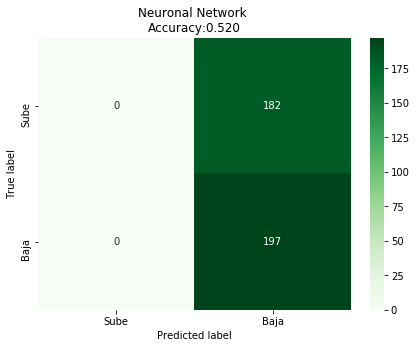

time: 3.69 s


In [36]:

# Creates a confusion matrix
cm = confusion_matrix(testing_cp.Label, testing_cp.Prediction) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Sube','Baja'], 
                     columns = ['Sube','Baja'])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap="Greens", fmt='g')
plt.title('Neuronal Network \nAccuracy:{0:.3f}'.format(accuracy_score(testing_cp.Label, testing_cp.Prediction)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [37]:
%%javascript
Jupyter.notebook.save_checkpoint()

<IPython.core.display.Javascript object>

time: 4 ms


In [38]:
from time import sleep
sleep(60)

time: 1min


In [39]:
from shutil import copyfile
copyfile('RNN_Model_Base_GPU_m3.ipynb', folder + '/RNN_Model_Base.ipynb' )

'Resultados/7/RNN_Model_Base.ipynb'

time: 274 ms
